In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
from torch.nn import functional as F

import timm
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

from torch.utils.data import Dataset, DataLoader

## Labels

In [4]:
path_classes = Path("/notebooks/data/CamVid/class_dict.csv")
df = pd.read_csv(path_classes)
labels = df.values[:,1:].astype('int16').transpose()

In [61]:
df

,name,r,g,b
0,Animal,64,128,64
1,Archway,192,0,128
2,Bicyclist,0,128,192
3,Bridge,0,128,64
4,Building,128,0,0
5,Car,64,0,128
6,CartLuggagePram,64,0,192
7,Child,192,128,64
8,Column_Pole,192,192,128
9,Fence,64,64,128


In [60]:
labels.shape

(3, 32)

## Images

In [7]:
train_path = Path("/notebooks/data/CamVid/train/")
train_labels_path = Path("/notebooks/data/CamVid/train_labels/")

In [8]:
images_pairs = [(path, train_labels_path / f"{path.stem}_L.png" ) for path in train_path.iterdir()]

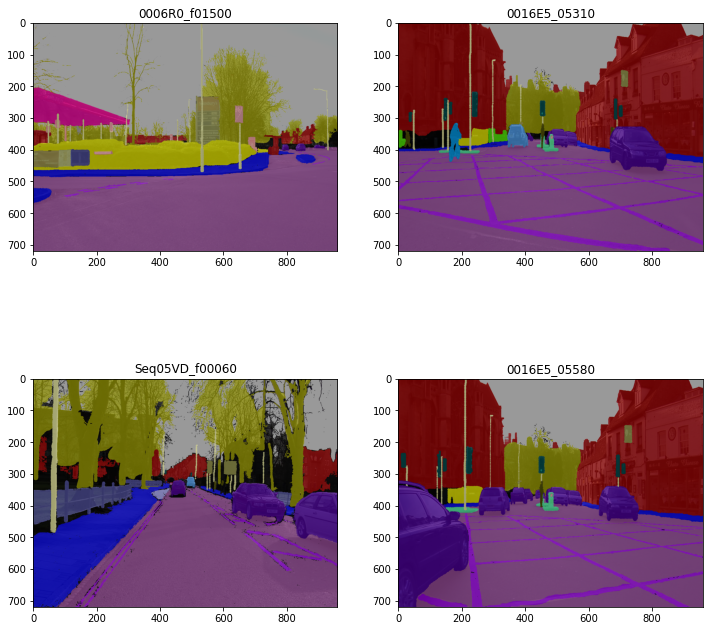

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12,12))
axes = axes.ravel()
for ax, (path_image, path_mask) in zip(axes, images_pairs[4:8]):
    image = Image.open(path_image)
    mask = Image.open(path_mask)
    ax.imshow(image)
    ax.imshow(mask, alpha=0.8)
    ax.set_title(path_image.stem)

In [10]:
image_data = np.asarray(image)
mask_data = np.asarray(mask)

In [11]:
def mask_into_classes(mask):
    comparison = np.expand_dims(mask_data,axis=-1) == labels
    indicators = np.all(comparison, axis=2)
    classes = np.argmax(indicators, axis=2)
    return classes

In [15]:
classes.shape

(720, 960)

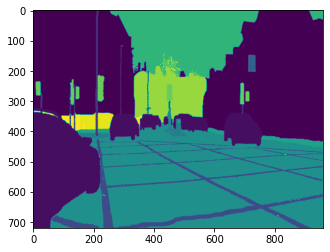

In [14]:
classes = mask_into_classes(mask_data)
plt.imshow(classes)

In [23]:
data_paths = {
    "train": {
        "images": Path("/notebooks/data/CamVid/train/"),
        "masks": Path("/notebooks/data/CamVid/train_labels/")
    },
    "test": {
        "images": Path("/notebooks/data/CamVid/test/"),
        "masks": Path("/notebooks/data/CamVid/test_labels/")
    },
    "valid": {
        "images": Path("/notebooks/data/CamVid/val/"),
        "masks": Path("/notebooks/data/CamVid/val_labels/")
    },
}

In [52]:
def get_data(phase="train"):
    if phase not in ["train", "test", "valid"]:
        raise ValueError(f"Data is not available for such a phase [{phase}]")
        
    images_path = data_paths[phase]["images"]
    masks_path = data_paths[phase]["masks"]
    
    images_pairs = [(path, masks_path / f"{path.stem}_L.png" ) for path in images_path.glob("*.png")]
    data = []
    for (path_image, path_mask) in tqdm(images_pairs[:10]):
        image = Image.open(path_image)
        mask = Image.open(path_mask)
        image_data = np.asarray(image)
        mask_data = np.asarray(mask)
        classes = mask_into_classes(mask_data)
        data.append({"path": path_image, "image": image_data, "classes": classes})
    return data

In [56]:
class CamVidDataset(Dataset):
    
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = data[idx]["image"].copy()
        classes = torch.from_numpy(data[idx]["classes"].copy())
        if self.transform is None:
            return img, classes
        else:
            return self.transform(img), classes

In [57]:
dataset = CamVidDataset(get_data("train"))

100%|██████████| 10/10 [00:02<00:00,  4.19it/s]
